# Regresión con Monte Carlo Markov Chain (MCMC)
Metropolis Hastings Random Walk (MHRW)

**Construcción de los datos**

Dado $z=ax^2 + bx + cx + \epsilon$ con $\epsilon \sim N( (0 \ 0 \ 0)^{T}, I_{3\times 3}$ se debe obtener $a, b$ y $c$. Las incognitas $a,b,c$ no tienen correlación y $x,y\in \mathbb{R}$.

In [14]:
using Random

Random.seed!(42) #Semilla

#rand() genera números aleatorios en (0,1)
x = 3 * rand(100)
y = 4 * rand(100)

#randn() produce números aleatorios de la distribución normal estándar
z = 2 * x.^2 - 1 * x + 3 * y + randn(100); # Modelo

En la construcción del modelo se supone que $a=2, b=-1$ y $c=3$. El modelo y los datos se grafican a continuación.

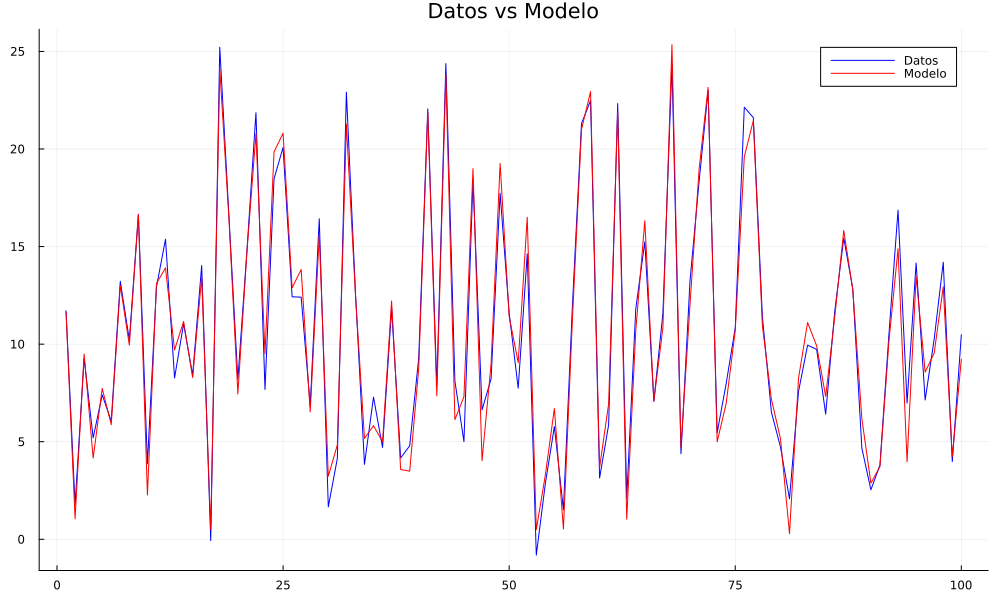

In [15]:
using Plots
plot(1:100,z,color="blue",label="Datos",title="Datos vs Modelo", size=(1000, 600))
plot!(1:100,2 * x.^2 - 1 * x + 3 * y,color="red",label="Modelo")

Si usamos regresión tradicional obtenemos que el valor de $a,b$ y $c$ es:

inv(Xreg' * Xreg) * Xreg' * z = [1.9867070705938659, -0.9182548691158843, 2.979184899872598]


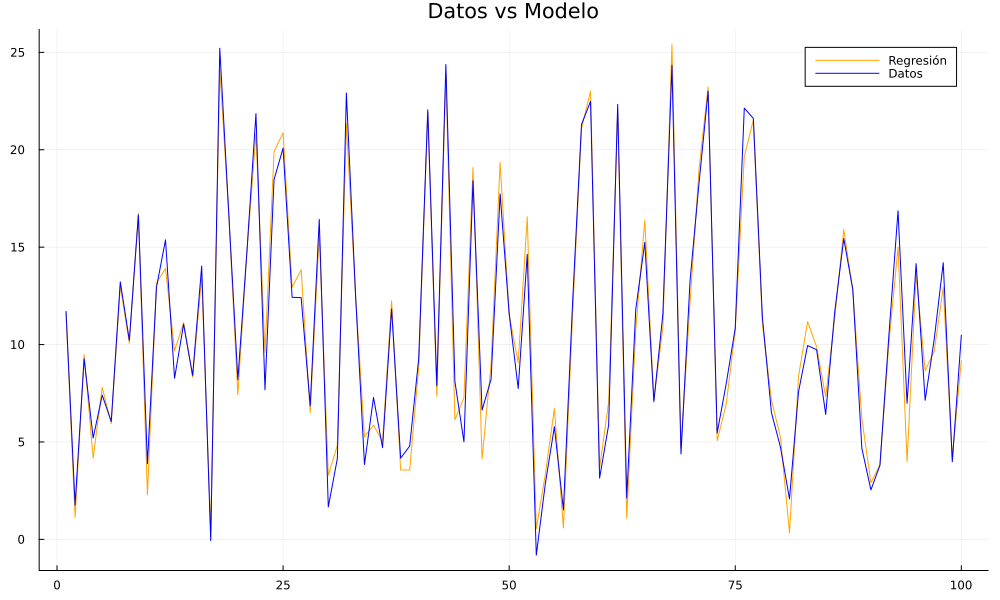

In [17]:
Xreg = [x.^2 x y]
@show inv(Xreg' * Xreg) * Xreg'*z
plot(1:100, Xreg*inv(Xreg' * Xreg) * Xreg'*z, color="orange",label="Regresión" ,title="Datos vs Modelo", size=(1000, 600))
plot!(1:100, z,color="blue",label="Datos")

**Construcción de la verosimilitud**

Recordemos que $\pi(y|x)$ corresponde a la verosimilitud del modelo, es decir, en qué medidad se ajustan los datos dado que ya conocemos los parámetros; de resultados previos se tiene que 
$$ 
\pi(y|x) = \pi_{ruido}(z-F(x,y,a,b,c)|(a,b,c)) 
$$
con $F(x,y,a,b,c) = a x^2 + b x + cy)$, y como la distribución  del ruido es normal multivariada estándar, entonces:
$$
\pi(y|x) = \frac{1}{(2\pi)^{3/2}|I|^{1/2}} e^{-\frac{1}{2}(z-(ax^2+bx+cy))^{T}I^{-1}(z-(ax^2+bx+cy))} = \frac{1}{(2\pi)^{3/2}} e^{-\frac{1}{2}(z-(ax^2+bx+cy))^{T}(z-(ax^2+bx+cy))}
$$

In [18]:
function p(th)
    (2*pi)^(-3/2) * exp(-0.5*sum((z-(th[1] * x.^2 + th[2] * x + th[3] * y)).^2))
end

p (generic function with 1 method)

**Metropolis Hastings Random Walk (MHRW)**

Se tomaran un número de muestras igual al número de iteraciones del algoritmo. Empezamos con un punto de partida $samples = ones(3,1)$ que corresponde al valor de $a,b$ y $c$, también inicializamos la verosimilitud del modelo en la variable $probabilities$.

In [19]:
iterations = 10000
samples = ones(3, 1)  # a, b, c
probabilities = [p(samples[:,end])]

1-element Vector{Float64}:
 0.0

Para variar los valores iniciales de $a,b$ y $c$ le añadimos un ruido gaussiano con media cero y una desviación estándar de:

In [20]:
sd = 0.2

0.2

El algoritmo de Metrópolis Hastings es el siguiente:

In [22]:
for i in 1:iterations
    theta = samples[:,end]+ sd * randn(3)
    p1 = p(theta)
    p2 = p(samples[:,end])
    alpha = min(1, p1/p2)
    u = rand()
    if u < alpha
        samples = hcat(samples, theta)
        probabilities = hcat(probabilities,p1)
    else
        samples = hcat(samples, samples[:,end])
        probabilities = hcat(probabilities,p2)
    end
end

**Muestreo sistemático**

El muestro sistemático es una técnica de muestreo en la que se seleccionan elementos de una población en intervalos regulares después de haber seleccionado un elemento de inicio de forma aleatoria.

In [23]:
initial_position = floor(10*rand())
leap = 10
samples_ss = samples[:, Int(initial_position):leap:end]
probabilities_ss = probabilities[Int(initial_position):leap:end];

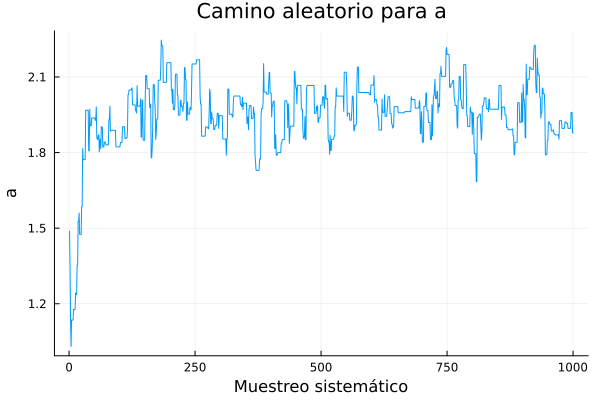

In [24]:
plot(1:1000, samples_ss[1, :], label=false, xlabel="Muestreo sistemático", ylabel="a")
title!("Camino aleatorio para a")

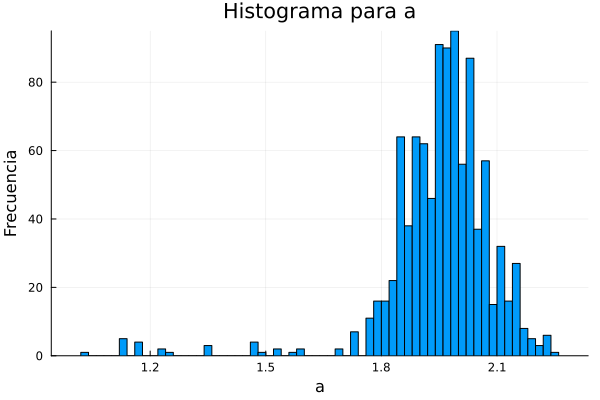

In [25]:
histogram(samples_ss[1, :], bins=100, label = false ,xlabel="a", ylabel="Frecuencia")
title!("Histograma para a")

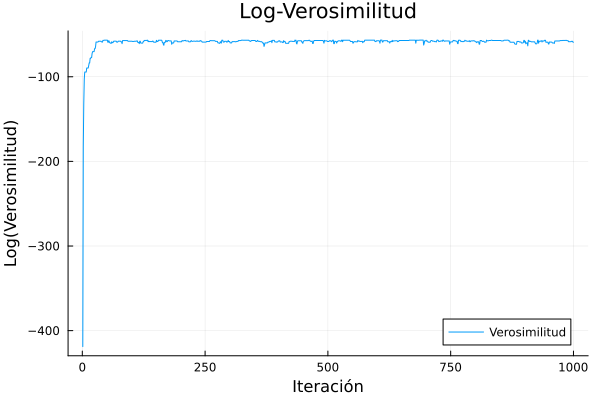

In [26]:
plot(1:1000, log.(probabilities_ss), label="Verosimilitud", xlabel="Iteración", ylabel="Log(Verosimilitud)")
title!("Log-Verosimilitud")

Algunos histogramas en dos dimensiones de los parámetros $a,b$ y $c$ son mostrados a continuación.

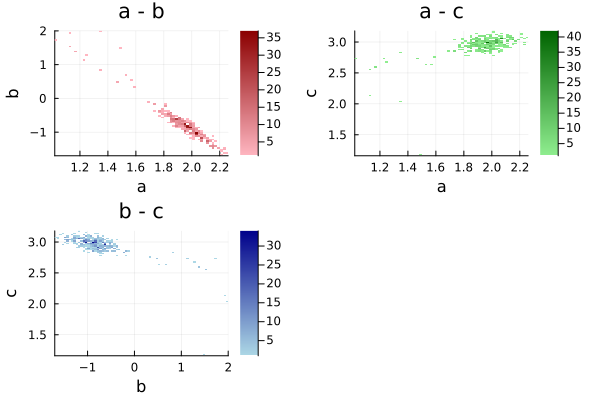

In [27]:
h1 = histogram2d(samples_ss[1, :], samples_ss[2, :], bins=100, c=:reds, xlabel="a", ylabel="b", title="a - b")
h2 = histogram2d(samples_ss[1, :], samples_ss[3, :], bins=100, c=:greens, xlabel="a", ylabel="c", title="a - c")
h3 = histogram2d(samples_ss[2, :], samples_ss[3, :], bins=100, c=:blues, xlabel="b", ylabel="c", title="b - c")
plot(h1,h2,h3,layout=(2,2))

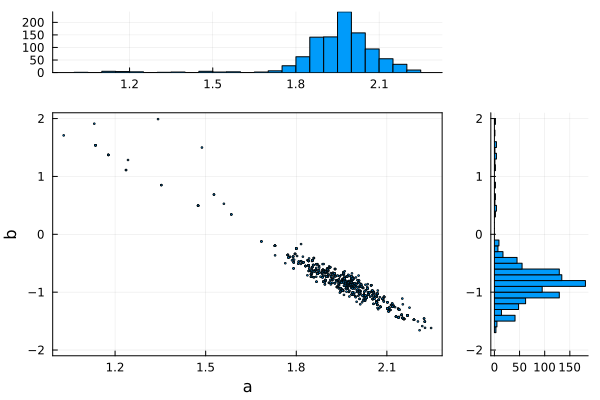

In [28]:
x = samples_ss[1, :]
y = samples_ss[2, :]
# Gráfico principal con la nube de puntos
sxy = scatter(x, y, markersize=1,
    xlabel="a", ylabel="b", border=:box,ylims=(-2.1, 2.1))
# Histogramas marginales
hx = histogram(x)
hy = histogram(y, orientation=:horizontal,ylims=(-2.1, 2.1))
# Gráfico vacío para la esquina superior derecha
p5 = Plots.Plot()
# Cuadrícula de paneles
cuadricula = grid(2,2, heights=(0.2,0.8), widths=(0.8,0.2))
plot(hx, p5, sxy, hy, legend=:none, layout=cuadricula)

**Estimaciones**

Con el algoritmo de MH se construye una muestra de puntos $\{x_1,x_2,\ldots,x_N\}$ tal que su promedio es aproximadamente igual al valor de la esperanza de la distribución posterior de los valores de $a,b,c$.

In [29]:
using Statistics
# Estimations
max_prob, position = findmax(probabilities_ss)
Max_likelihood = samples_ss[:, position]
Mean = mean(samples_ss, dims=2)
@show max_prob
@show Max_likelihood
@show Mean;

max_prob = 2.5210482348668383e-25
Max_likelihood = [1.9879148966588682, -0.9125478888533409, 2.9840433690113333]
Mean = [1.952965652592925; -0.8195805952153845; 2.962086722942085;;]


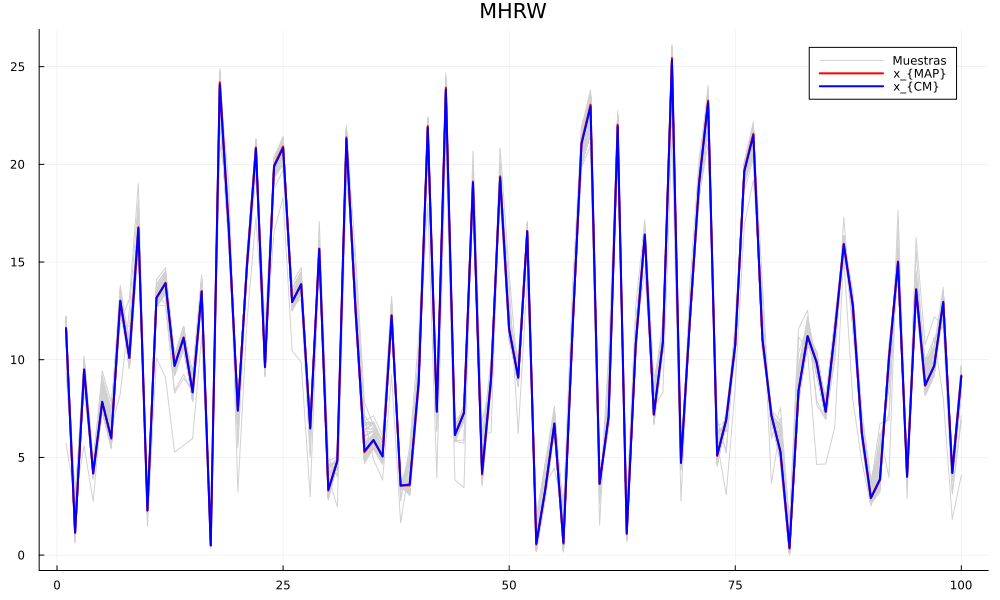

In [30]:
plot(1:100,Xreg*samples_ss[:,size(samples_ss)[2]],color="gray82",title="MHRW",label="Muestras",z=1,size=(1000, 600))
for j=1:(size(samples_ss)[2]-1)
    plot!(1:100,Xreg*samples_ss[:,j],color="gray82",label=false,z=1)
end
plot!(1:100,Xreg*Max_likelihood, color="red", label="x_{MAP}",z=3,linewidth=2)
plot!(1:100,Xreg*Mean, color="blue", label="x_{CM}",z=3,linewidth=2)